In [1]:
import time,datetime

import numpy as np
import tables as t
import pandas as pd

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import os
import json

from BKG_Dataholder import BKG_dataholder
import matplotlib.pyplot as plt

%matplotlib inline 

# Paths and constants

In [2]:
COLLIMATOR_VARIABLES = [        
        ":SET_LD",
        #":SET_LU",
        ":SET_RD",
        #":SET_RU"
        ]

COLLIMATOR_PATH = "/home/mirksonius/Desktop/Fill_info/collimators/"

BEAM_PATH = "/home/mirksonius/Desktop/Fill_info/beam/"


FILL_PATH = "/home/mirksonius/Desktop/22_fills/"
FILL_NUMBER =  8099


In [3]:
class Coll_Data_Augmentator():

    def __init__(self,coll_dict:dict,before_ip:list,
    beam_1:list,beam_2:list,variables:list = COLLIMATOR_VARIABLES,times = None):
        self.coll_dict = coll_dict
        self.colls = list(self.coll_dict.keys())
        self.beam1 = beam_1
        self.beam2 = beam_2
        self.before_ip = before_ip
        self.variables = variables
        self.beams = {1:self.beam1,2:self.beam2}
        #Hardcoded: NEEDS FIXING!!!
        self.hv_pairs = {1:(self.before_ip[0],self.before_ip[2]),
                         2:(self.before_ip[1],self.before_ip[3])}
    
        self.augmented = {}
        self.extended = False

        if times is not None:
            self.extend_data(times)
        
        

    def extend_data(self,times):
        new_data = {}
        for c in self.coll_dict.keys():
            var_data = {}
            for var in self.variables:
                collimator = self.coll_dict[c]
                var_data.update( {c+var : pd.DataFrame(
                    data = {"timestamp":times,
                    "position":self.extend_positions(collimator,c+var,times)
                    })})
            new_data.update({c : var_data})
        self.extended = True
        self.coll_dict = new_data


    def extend_positions(self,collimator,var,times):
        positions = np.zeros(times.shape) + collimator[var]["position"].iloc[0]
        change_times = collimator[var]["timestamp"]
        for i,ts in enumerate(change_times):
            positions[times>ts] = collimator[var]["position"].iloc[i]

        return positions

    def minimal_separation(self,beam:int):
        pass        
            
    
    
    def maximal_separation(self,beam:int):
        pass

    def area(self,beam:int):
        if self.extended == False:
            print("Data not extended!!")
            return -1
        

        area = []
        h,v =  self.hv_pairs[beam]
        hor = self.coll_dict[h]
        vert = self.coll_dict[v]
        ud_h = list(hor.keys())
        ud_v = list(vert.keys())
        N = len(hor[ud_h[0]]["timestamp"])
        area = np.zeros(N)
        for i in range(N):
            hgap = hor[ud_h[0]]["position"].iloc[i] - hor[ud_h[1]]["position"].iloc[i]
            vgap = vert[ud_v[0]]["position"].iloc[i] - vert[ud_v[1]]["position"].iloc[i]
            area[i] = hgap*vgap
        return np.array(area)

    def get_unique_positions(self,coll,var):
        return np.unique(
                self.coll_dict[coll][ var]["position"],
                return_index = True
            )
    

    def distribution_over_pos(self,coll,var,bkg,times):
        pos,idx = self.get_unique_positions(coll,var)
        bkg_pos = {}
        for p in pos:        
            ts = self.coll_dict[coll][var].loc[
                self.coll_dict[coll][var]["position"] == p]
            print(ts.index) 
            placeholder = bkg[ts.index]
            bkg_pos[p] = placeholder[np.nonzero(placeholder)]
        return bkg_pos

        

## Defining background dataholder and getting data

In [4]:
bkg = BKG_dataholder(
    fill_path= FILL_PATH,
    fill_number= FILL_NUMBER,
    collimator_path= COLLIMATOR_PATH,
    beam_path = BEAM_PATH
        )
              
bkg.get_beam_data()
bkg.get_fill_data()
bkg.collimator_variables = COLLIMATOR_VARIABLES
bkg.get_collimator_data()

Opening file 8099_356916_2208060210_2208060231.hd5
File 8099_356916_2208060210_2208060231.hd5 starts at 2022-08-06 02:30:33 and ends at 2022-08-06 02:34:13
Opening file 8099_356917_2208060231_2208060340.hd5
File 8099_356917_2208060231_2208060340.hd5 starts at 2022-08-06 02:34:15 and ends at 2022-08-06 03:41:41
Opening file 8099_356918_2208060340_2208060343.hd5
File 8099_356918_2208060340_2208060343.hd5 starts at 2022-08-06 03:41:42 and ends at 2022-08-06 03:45:50
Opening file 8099_356919_2208060343_2208060432.hd5
File 8099_356919_2208060343_2208060432.hd5 starts at 2022-08-06 03:45:51 and ends at 2022-08-06 04:35:08


In [33]:
print(bkg.collimators_b1)
print(bkg.collimators_b2)

COLLIMATOR_COLORS = ["mediumslateblue","red","black","darkviolet","lightcoral"]

BEFORE_IP = [
    "TCTPH.4L5.B1",
    "TCTPH.4R5.B2",
    "TCTPV.4L5.B1",
    "TCTPV.4R5.B2"
    ]

import pytz

def get_xlabels(timestamps):
    dates = []
    
    for t in timestamps:
        d = datetime.datetime.utcfromtimestamp(t)
        #d = datetime.datetime.fromtimestamp(t)
        dates.append(
            #time.strftime("%H:%M:%S", time.gmtime(t))
            
            datetime.time(hour = d.hour,
                            minute= d.minute,
                            second= d.second,
                                )
        )
    return dates


['TCTPH.4L5.B1', 'TCTPV.4L5.B1', 'TCL.4R5.B1', 'TCL.5R5.B1', 'TCL.6R5.B1']
['TCTPH.4R5.B2', 'TCTPV.4R5.B2', 'TCL.4L5.B2', 'TCL.5L5.B2', 'TCL.6L5.B2']


## Exponential mean definition

In [6]:
def get_exp_mean(signal,alpha:float = 1e-3):
    """
    signal: iterable on which the exponential average should be
    calculated on
    alpha: importance of new value
    """
    N = len(signal)
    expavg = signal[0]
    res = [expavg]
    for i in range(1,N):
        expavg = alpha * signal[i] + (1-alpha)*expavg
        res.append(expavg)
    return res

In [7]:
for c in bkg.collimators_b1:
    print(bkg.coll_dict[c].keys())

dict_keys(['TCTPH.4L5.B1:SET_LD', 'TCTPH.4L5.B1:SET_RD'])
dict_keys(['TCTPV.4L5.B1:SET_LD', 'TCTPV.4L5.B1:SET_RD'])
dict_keys(['TCL.4R5.B1:SET_LD', 'TCL.4R5.B1:SET_RD'])
dict_keys(['TCL.5R5.B1:SET_LD', 'TCL.5R5.B1:SET_RD'])
dict_keys(['TCL.6R5.B1:SET_LD', 'TCL.6R5.B1:SET_RD'])


In [8]:
cda = Coll_Data_Augmentator(
    bkg.coll_dict,BEFORE_IP,
    bkg.collimators_b1, bkg.collimators_b2,
    times = bkg.times
                        )


area1 = cda.area(1)
area2 = cda.area(2)

## Getting exponential averages

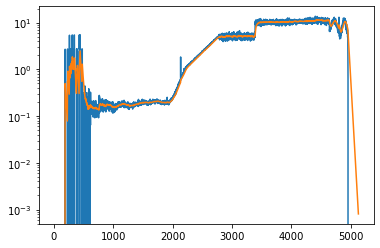

In [9]:
plus_eavg = get_exp_mean(bkg.plusz,alpha = 5e-2)
minus_eavg = get_exp_mean(bkg.minusz,alpha = 5e-2)
plt.plot(bkg.plusz)
plt.plot(plus_eavg)
plt.yscale("log")


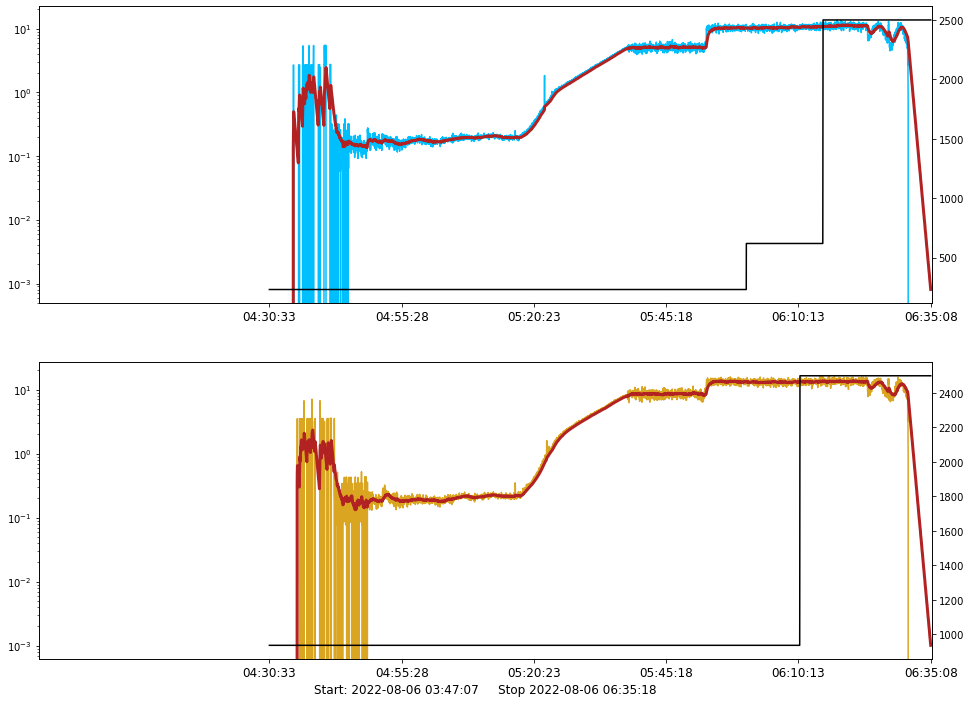

In [32]:


frame,fig = plt.subplots(2,1,figsize = (16,12))
fig[0].plot(bkg.times,bkg.plusz,color = "deepskyblue")
#tw0 = fig[0].twinx()



fig[1].plot(bkg.times,bkg.minusz, color = "goldenrod")
#tw1 = fig[1].twinx()

for i,(c1,c2) in enumerate(zip(
    bkg.collimators_b1,bkg.collimators_b2)):

    continue
    if c1 in BEFORE_IP:
        for var in bkg.coll_dict[c1].keys():
            tw0.plot(
                bkg.coll_dict[c1][var]["timestamp"],
                bkg.coll_dict[c1][var]["position"],
                color = COLLIMATOR_COLORS[i],
                label = var
                )
            

    if c2 in BEFORE_IP:
        for var in bkg.coll_dict[c2].keys():
            tw1.plot(
                bkg.coll_dict[c2][var]["timestamp"],
                bkg.coll_dict[c2][var]["position"],
                color = COLLIMATOR_COLORS[i],
                label = var
                )


tw_area1 = fig[0].twinx()
tw_area1.plot(bkg.times,area1,color = "black",linewidth = 1.5)#,linestyle = "--")

tw_area2 = fig[1].twinx()
tw_area2.plot(bkg.times,area2,color = "black",linewidth = 1.5)#,linestyle = "--")


#fig[0]

fig[0].plot(bkg.times,plus_eavg,color = "firebrick",linewidth = 3)
fig[1].plot(bkg.times,minus_eavg,color = "firebrick",linewidth = 3)

t0 = np.min(bkg.times)
t1 = np.max(bkg.times)
ticks = np.linspace(t0,t1,6,endpoint=True,dtype="int")
lab = get_xlabels(ticks)
fig[0].set_xticks(ticks)
fig[0].set_xticklabels(lab,fontsize = 12)
fig[0].set_xlim(bkg.fill_start,bkg.fill_end)

fig[1].set_xticks(ticks)
fig[1].set_xticklabels(lab,fontsize = 12)


fig[1].set_xlim(bkg.fill_start,bkg.fill_end)
fig[1].set_xlabel(
    "Start: {}     Stop {}".format(bkg.fill_start_dt,bkg.fill_end_dt),fontsize = 12)


for f in fig:
    #continue
    f.set_yscale("log")

#tw0.legend(fontsize = 15)
#tw1.legend(fontsize = 15)




In [11]:
for coll in bkg.collimators_b1:
    print(coll)
    for var in COLLIMATOR_VARIABLES:
        #print(bkg.coll_dict[coll][coll + var]["timestamp"].values)
        print(
                bkg.coll_dict[coll][coll + var]["position"].loc[
                    bkg.coll_dict[coll][coll + var]["timestamp"].values < bkg.times[1000] ]
    
        )

TCTPH.4L5.B1
Series([], Name: position, dtype: float64)
Series([], Name: position, dtype: float64)
TCTPV.4L5.B1
Series([], Name: position, dtype: float64)
Series([], Name: position, dtype: float64)
TCL.4R5.B1
Series([], Name: position, dtype: float64)
Series([], Name: position, dtype: float64)
TCL.5R5.B1
Series([], Name: position, dtype: float64)
Series([], Name: position, dtype: float64)
TCL.6R5.B1
Series([], Name: position, dtype: float64)
Series([], Name: position, dtype: float64)


2
2
3
3
4
4


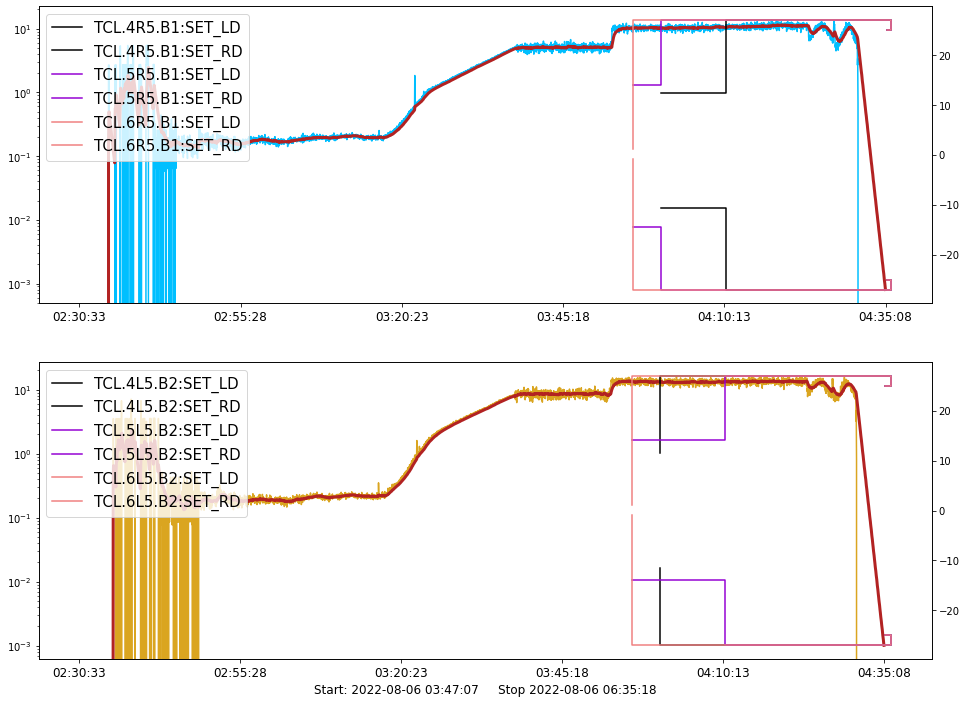

In [12]:



frame,fig = plt.subplots(2,1,figsize = (16,12))
fig[0].plot(bkg.times,bkg.plusz,color = "deepskyblue")
tw0 = fig[0].twinx()



fig[1].plot(bkg.times,bkg.minusz, color = "goldenrod")
tw1 = fig[1].twinx()

for i,(c1,c2) in enumerate(zip(
    bkg.collimators_b1,bkg.collimators_b2)):

    #continue
    if c1 not in BEFORE_IP:
        for var in bkg.coll_dict[c1].keys():
            tw0.plot(
                bkg.coll_dict[c1][var]["timestamp"],
                bkg.coll_dict[c1][var]["position"],
                color = COLLIMATOR_COLORS[i],
                label = var
                )
            

    if c2 not in BEFORE_IP:
        for var in bkg.coll_dict[c2].keys():
            tw1.plot(
                bkg.coll_dict[c2][var]["timestamp"],
                bkg.coll_dict[c2][var]["position"],
                color = COLLIMATOR_COLORS[i],
                label = var
                )


#tw_area1 = fig[0].twinx()
#tw_area1.plot(bkg.times,area1,color = "black",linewidth = 3,linestyle = "--")

#tw_area2 = fig[1].twinx()
#tw_area2.plot(bkg.times,area2,color = "black",linewidth = 3,linestyle = "--")


#fig[0]

fig[0].plot(bkg.times,plus_eavg,color = "firebrick",linewidth = 3)
fig[1].plot(bkg.times,minus_eavg,color = "firebrick",linewidth = 3)

t0 = np.min(bkg.times)
t1 = np.max(bkg.times)
ticks = np.linspace(t0,t1,6,endpoint=True,dtype="int")
lab = get_xlabels(ticks)
fig[0].set_xticks(ticks)
fig[0].set_xticklabels(lab,fontsize = 12)

fig[1].set_xticks(ticks)
fig[1].set_xticklabels(lab,fontsize = 12)


#fig[1].set_xlim(bkg.fill_start,bkg.fill_end)
fig[1].set_xlabel(
    "Start: {}     Stop {}".format(bkg.fill_start_dt,bkg.fill_end_dt),fontsize = 12)


for f in fig:
    #continue
    f.set_yscale("log")


tw0.legend(fontsize = 15)
tw1.legend(fontsize = 15)



In [13]:
c = list(bkg.coll_dict.keys())[0]


cda = Coll_Data_Augmentator(
    bkg.coll_dict,BEFORE_IP,
    bkg.collimators_b1, bkg.collimators_b2
                        )


cda.extend_data(bkg.times)


Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            3690, 3691, 3692, 3693, 3694, 3695, 3696, 3697, 3698, 3699],
           dtype='int64', length=3700)
Int64Index([3700, 3701, 3702, 3703, 3704, 3705, 3706, 3707, 3708, 3709,
            ...
            5121, 5122, 5123, 5124, 5125, 5126, 5127, 5128, 5129, 5130],
           dtype='int64', length=1431)


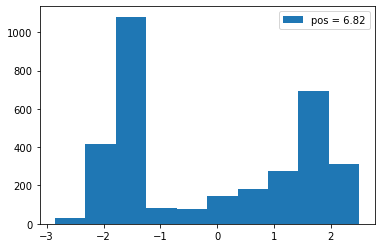

In [15]:
bkg_pos = cda.distribution_over_pos(cda.colls[0],cda.colls[0] + COLLIMATOR_VARIABLES[0],
    bkg.plusz,bkg.times)

pos = list(bkg_pos.keys())
for i in range(0,len(pos),5):

    plt.hist(np.log(bkg_pos[pos[i]]), label = "pos = {:0.2f}".format(pos[i]))

plt.legend()

In [24]:
import time

time.strftime("%H:%M:%S", time.gmtime())

TypeError: 'list' object cannot be interpreted as an integer